In [3]:
import pandas as pd
import gurobipy as gb
from gurobipy import GRB
import matplotlib.pyplot as plt

In [4]:
# Load data
hotel_data = pd.read_csv('hotels.csv')
hotel_data.head()

,Room_ID,Floor,Square_Feet,Cleaning_Time_Hours
0,1,3,682,1.814545
1,2,9,223,0.562727
2,3,7,506,1.334545
3,4,1,561,1.484545
4,5,14,424,1.110909


In [5]:
num_rooms = hotel_data.shape[0]
num_attendants = 8
regular_wage = 25  # hourly wage
overtime_wage = 1.5 * regular_wage  # overtime wage (1.5x regular wage)
double_overtime_wage = 2 * regular_wage  # alternative scenario
max_regular_hours = 8
max_overtime_hours = 2
max_floors = 4
bonus_per_extra_floor = 75
max_sq_ft = 3500
sq_ft_per_room = 200

In [6]:
scheduling_model = gb.Model("Hotel Worker Scheduling")

Set parameter Username
Set parameter LicenseID to value 2615198
Academic license - for non-commercial use only - expires 2026-01-25


In [7]:
# Decision Variables
f = scheduling_model.addVars(num_attendants, num_rooms, vtype=GRB.BINARY, name="f")  # Assignment variable
fik = scheduling_model.addVars(num_attendants, max_floors, vtype=GRB.BINARY, name="fik")  # Floor assignment variable
overtime = scheduling_model.addVars(num_attendants, vtype=GRB.CONTINUOUS, name="overtime")  # Overtime hours
extra_pay = scheduling_model.addVars(num_attendants, vtype=GRB.CONTINUOUS, name="extra_pay")  # Extra pay for exceeding sq ft limit

In [8]:
# Constraints
scheduling_model.addConstrs((gb.quicksum(f[i, k] for i in range(num_attendants)) == 1 for k in range(num_rooms)), name="RoomAssignment")


{0: <gurobi.Constr *Awaiting Model Update*>,
 1: <gurobi.Constr *Awaiting Model Update*>,
 2: <gurobi.Constr *Awaiting Model Update*>,
 3: <gurobi.Constr *Awaiting Model Update*>,
 4: <gurobi.Constr *Awaiting Model Update*>,
 5: <gurobi.Constr *Awaiting Model Update*>,
 6: <gurobi.Constr *Awaiting Model Update*>,
 7: <gurobi.Constr *Awaiting Model Update*>,
 8: <gurobi.Constr *Awaiting Model Update*>,
 9: <gurobi.Constr *Awaiting Model Update*>,
 10: <gurobi.Constr *Awaiting Model Update*>,
 11: <gurobi.Constr *Awaiting Model Update*>,
 12: <gurobi.Constr *Awaiting Model Update*>,
 13: <gurobi.Constr *Awaiting Model Update*>,
 14: <gurobi.Constr *Awaiting Model Update*>,
 15: <gurobi.Constr *Awaiting Model Update*>,
 16: <gurobi.Constr *Awaiting Model Update*>,
 17: <gurobi.Constr *Awaiting Model Update*>,
 18: <gurobi.Constr *Awaiting Model Update*>,
 19: <gurobi.Constr *Awaiting Model Update*>,
 20: <gurobi.Constr *Awaiting Model Update*>,
 21: <gurobi.Constr *Awaiting Model Update*>

In [9]:
scheduling_model.addConstrs((
    gb.quicksum(f[i, k] * hotel_data.iloc[k]['Cleaning_Time_Hours'] for k in range(num_rooms)) <= max_regular_hours + overtime[i] 
    for i in range(num_attendants)
), name="WorkLimit")

{0: <gurobi.Constr *Awaiting Model Update*>,
 1: <gurobi.Constr *Awaiting Model Update*>,
 2: <gurobi.Constr *Awaiting Model Update*>,
 3: <gurobi.Constr *Awaiting Model Update*>,
 4: <gurobi.Constr *Awaiting Model Update*>,
 5: <gurobi.Constr *Awaiting Model Update*>,
 6: <gurobi.Constr *Awaiting Model Update*>,
 7: <gurobi.Constr *Awaiting Model Update*>}

In [10]:
scheduling_model.addConstrs((overtime[i] <= max_overtime_hours for i in range(num_attendants)), name="OvertimeLimit")


{0: <gurobi.Constr *Awaiting Model Update*>,
 1: <gurobi.Constr *Awaiting Model Update*>,
 2: <gurobi.Constr *Awaiting Model Update*>,
 3: <gurobi.Constr *Awaiting Model Update*>,
 4: <gurobi.Constr *Awaiting Model Update*>,
 5: <gurobi.Constr *Awaiting Model Update*>,
 6: <gurobi.Constr *Awaiting Model Update*>,
 7: <gurobi.Constr *Awaiting Model Update*>}

In [11]:
scheduling_model.addConstrs((
    fik[i, k] >= gb.quicksum(f[i, r] for r in range(num_rooms) if hotel_data.iloc[r]['Floor'] == k) / num_rooms
    for i in range(num_attendants) for k in range(max_floors)
), name="FloorAssignment")

{(0, 0): <gurobi.Constr *Awaiting Model Update*>,
 (0, 1): <gurobi.Constr *Awaiting Model Update*>,
 (0, 2): <gurobi.Constr *Awaiting Model Update*>,
 (0, 3): <gurobi.Constr *Awaiting Model Update*>,
 (1, 0): <gurobi.Constr *Awaiting Model Update*>,
 (1, 1): <gurobi.Constr *Awaiting Model Update*>,
 (1, 2): <gurobi.Constr *Awaiting Model Update*>,
 (1, 3): <gurobi.Constr *Awaiting Model Update*>,
 (2, 0): <gurobi.Constr *Awaiting Model Update*>,
 (2, 1): <gurobi.Constr *Awaiting Model Update*>,
 (2, 2): <gurobi.Constr *Awaiting Model Update*>,
 (2, 3): <gurobi.Constr *Awaiting Model Update*>,
 (3, 0): <gurobi.Constr *Awaiting Model Update*>,
 (3, 1): <gurobi.Constr *Awaiting Model Update*>,
 (3, 2): <gurobi.Constr *Awaiting Model Update*>,
 (3, 3): <gurobi.Constr *Awaiting Model Update*>,
 (4, 0): <gurobi.Constr *Awaiting Model Update*>,
 (4, 1): <gurobi.Constr *Awaiting Model Update*>,
 (4, 2): <gurobi.Constr *Awaiting Model Update*>,
 (4, 3): <gurobi.Constr *Awaiting Model Update*>,


In [12]:
scheduling_model.addConstrs((
    gb.quicksum(f[i, k] * hotel_data.iloc[k]['Square_Feet'] for k in range(num_rooms)) <= max_sq_ft + extra_pay[i] 
    for i in range(num_attendants)
), name="SquareFootLimit")

{0: <gurobi.Constr *Awaiting Model Update*>,
 1: <gurobi.Constr *Awaiting Model Update*>,
 2: <gurobi.Constr *Awaiting Model Update*>,
 3: <gurobi.Constr *Awaiting Model Update*>,
 4: <gurobi.Constr *Awaiting Model Update*>,
 5: <gurobi.Constr *Awaiting Model Update*>,
 6: <gurobi.Constr *Awaiting Model Update*>,
 7: <gurobi.Constr *Awaiting Model Update*>}

In [13]:
# Objective function: minimize cost
scheduling_model.setObjective(
    gb.quicksum(f[i, k] * hotel_data.iloc[k]['Cleaning_Time_Hours'] * regular_wage for i in range(num_attendants) for k in range(num_rooms)) +
    gb.quicksum(overtime[i] * overtime_wage for i in range(num_attendants)) +
    gb.quicksum(fik[i, k] * bonus_per_extra_floor for i in range(num_attendants) for k in range(max_floors)) +
    gb.quicksum(extra_pay[i] * regular_wage for i in range(num_attendants)),
    GRB.MINIMIZE
)

In [14]:
# Solve model
scheduling_model.optimize()

# Print results
print("Optimal Cost:", scheduling_model.objVal)
print("Total Overtime Hours:", sum(overtime[i].x for i in range(num_attendants)))
print("Total Extra Floor Payments:", sum(fik[i, k].x for i in range(num_attendants) for k in range(max_floors)))


Gurobi Optimizer version 12.0.0 build v12.0.0rc1 (mac64[x86] - Darwin 21.6.0 21H1123)

CPU model: Intel(R) Core(TM) i5-5350U CPU @ 1.80GHz
Thread count: 2 physical cores, 4 logical processors, using up to 4 threads

Optimize a model with 108 rows, 464 columns and 1368 nonzeros
Model fingerprint: 0x6c61f3ad
Variable types: 16 continuous, 448 integer (448 binary)
Coefficient statistics:
  Matrix range     [2e-02, 7e+02]
  Objective range  [1e+01, 8e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 4e+03]
Found heuristic solution: objective 11327.670455
Presolve removed 16 rows and 8 columns
Presolve time: 0.02s
Presolved: 92 rows, 456 columns, 1352 nonzeros
Variable types: 8 continuous, 448 integer (440 binary)

Root relaxation: objective 1.925852e+03, 131 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 1925.85227 

In [15]:
# Relaxation Analysis
relaxed_model = scheduling_model.relax()
relaxed_model.optimize()
print("Relaxed Optimal Cost:", relaxed_model.objVal)

Gurobi Optimizer version 12.0.0 build v12.0.0rc1 (mac64[x86] - Darwin 21.6.0 21H1123)

CPU model: Intel(R) Core(TM) i5-5350U CPU @ 1.80GHz
Thread count: 2 physical cores, 4 logical processors, using up to 4 threads

Optimize a model with 108 rows, 464 columns and 1368 nonzeros
Model fingerprint: 0xe7666c46
Coefficient statistics:
  Matrix range     [2e-02, 7e+02]
  Objective range  [1e+01, 8e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 4e+03]
Presolve removed 40 rows and 32 columns
Presolve time: 0.02s
Presolved: 68 rows, 432 columns, 1264 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    1.6518794e+03   7.271449e+02   0.000000e+00      0s
      80    1.7123907e+03   0.000000e+00   0.000000e+00      0s

Solved in 80 iterations and 0.03 seconds (0.00 work units)
Optimal objective  1.712390734e+03
Relaxed Optimal Cost: 1712.3907342657342


Gurobi Optimizer version 12.0.0 build v12.0.0rc1 (mac64[x86] - Darwin 21.6.0 21H1123)

CPU model: Intel(R) Core(TM) i5-5350U CPU @ 1.80GHz
Thread count: 2 physical cores, 4 logical processors, using up to 4 threads

Optimize a model with 108 rows, 464 columns and 1368 nonzeros
Model fingerprint: 0xe7666c46
Coefficient statistics:
  Matrix range     [2e-02, 7e+02]
  Objective range  [1e+01, 8e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 4e+03]
Presolve removed 40 rows and 32 columns
Presolve time: 0.02s
Presolved: 68 rows, 432 columns, 1264 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    1.6518794e+03   7.271449e+02   0.000000e+00      0s
      80    1.7123907e+03   0.000000e+00   0.000000e+00      0s

Solved in 80 iterations and 0.03 seconds (0.00 work units)
Optimal objective  1.712390734e+03


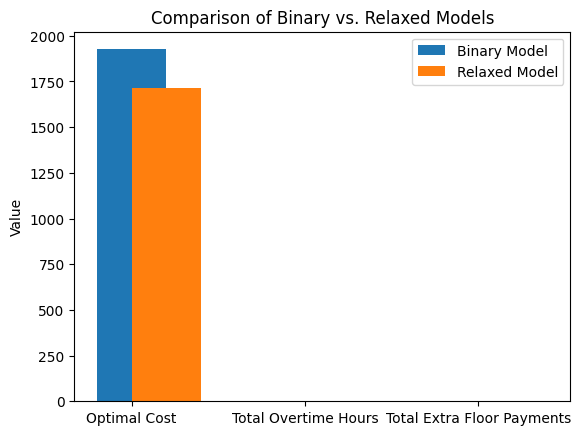

In [16]:
# Store results for visualization
binary_cost = scheduling_model.objVal
binary_overtime = sum(overtime[i].x for i in range(num_attendants))
binary_floors = sum(fik[i, k].x for i in range(num_attendants) for k in range(max_floors))

# Relaxation Analysis
relaxed_model = scheduling_model.relax()
relaxed_model.optimize()
relaxed_cost = relaxed_model.objVal

# Visualization
categories = ['Optimal Cost', 'Total Overtime Hours', 'Total Extra Floor Payments']
binary_values = [binary_cost, binary_overtime, binary_floors]
relaxed_values = [relaxed_cost, binary_overtime, binary_floors]

x = range(len(categories))
plt.bar(x, binary_values, width=0.4, label='Binary Model', align='center')
plt.bar(x, relaxed_values, width=0.4, label='Relaxed Model', align='edge')
plt.xticks(x, categories)
plt.ylabel('Value')
plt.title('Comparison of Binary vs. Relaxed Models')
plt.legend()
plt.show()

In [17]:
# Double overtime scenario
scheduling_model.getObjective().clear()
scheduling_model.setObjective(
    gb.quicksum(f[i, k] * hotel_data.iloc[k]['Cleaning_Time_Hours'] * regular_wage for i in range(num_attendants) for k in range(num_rooms)) +
    gb.quicksum(overtime[i] * double_overtime_wage for i in range(num_attendants)) +
    gb.quicksum(fik[i, k] * bonus_per_extra_floor for i in range(num_attendants) for k in range(max_floors)) +
    gb.quicksum(extra_pay[i] * regular_wage for i in range(num_attendants)),
    GRB.MINIMIZE
)

In [18]:
scheduling_model.optimize()
print("Optimal Cost (Double Overtime):", scheduling_model.objVal)


Gurobi Optimizer version 12.0.0 build v12.0.0rc1 (mac64[x86] - Darwin 21.6.0 21H1123)

CPU model: Intel(R) Core(TM) i5-5350U CPU @ 1.80GHz
Thread count: 2 physical cores, 4 logical processors, using up to 4 threads

Optimize a model with 108 rows, 464 columns and 1368 nonzeros
Model fingerprint: 0x8565a4d8
Variable types: 16 continuous, 448 integer (448 binary)
Coefficient statistics:
  Matrix range     [2e-02, 7e+02]
  Objective range  [1e+01, 8e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 4e+03]

MIP start from previous solve produced solution with objective 1946.02 (0.03s)
MIP start from previous solve produced solution with objective 1946.02 (0.03s)
Loaded MIP start from previous solve with objective 1946.02

Presolve removed 16 rows and 8 columns
Presolve time: 0.01s
Presolved: 92 rows, 456 columns, 1352 nonzeros
Variable types: 8 continuous, 448 integer (440 binary)

Root relaxation: cutoff, 131 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Cu

In [19]:
# Double overtime relaxation
relaxed_model = scheduling_model.relax()
relaxed_model.optimize()
print("Relaxed Optimal Cost (Double Overtime):", relaxed_model.objVal)  

Gurobi Optimizer version 12.0.0 build v12.0.0rc1 (mac64[x86] - Darwin 21.6.0 21H1123)

CPU model: Intel(R) Core(TM) i5-5350U CPU @ 1.80GHz
Thread count: 2 physical cores, 4 logical processors, using up to 4 threads

Optimize a model with 108 rows, 464 columns and 1368 nonzeros
Model fingerprint: 0xf07cf369
Coefficient statistics:
  Matrix range     [2e-02, 7e+02]
  Objective range  [1e+01, 8e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 4e+03]
Presolve removed 40 rows and 32 columns
Presolve time: 0.02s
Presolved: 68 rows, 432 columns, 1264 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    1.6518794e+03   7.271449e+02   0.000000e+00      0s
      80    1.7325612e+03   0.000000e+00   0.000000e+00      0s

Solved in 80 iterations and 0.04 seconds (0.00 work units)
Optimal objective  1.732561189e+03
Relaxed Optimal Cost (Double Overtime): 1732.5611888111885
